In [2]:
import sagemaker
sagemaker.get_execution_role()

'arn:aws:iam::203378532510:role/service-role/AmazonSageMaker-ExecutionRole-Interns'

In [3]:
import json
import os
import pickle as pkl
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

warnings.filterwarnings("ignore")

import AIPT.Models.Beshnova2020.CNN
import AIPT.Utils.logging
import AIPT.Utils.plotting

import AIPT.Utils.Dev.dev_utils as dev_utils

aipt_path = '/home/ec2-user/SageMaker/antibody-in-pytorch/'
aipt_reload = dev_utils.get_aipt_reload_fn(aipt_path)

os.chdir(aipt_path)
print("current working directory:")
%pwd

File: /home/ec2-user/SageMaker/.persisted_conda/aipt/lib/python3.6/site-packages/AIPT-0.0.1-py3.6.egg/AIPT/Models/Beshnova2020/CNN.py 
 Last modified: 2020-11-08 15:57:34 UTC
current working directory:


'/home/ec2-user/SageMaker/antibody-in-pytorch'

In [4]:
'''
set up paths
'''

aipt_dir = '/home/ec2-user/SageMaker/antibody-in-pytorch/AIPT' # replace with your own aipt path
# print("\t".join(os.listdir(aipt_dir)))
!ls {aipt_dir}

Benchmarks	__init__.py  Models	  Utils
entry_point.py	__main__.py  __pycache__


In [5]:
SEQ_LENGTH = 12
toy = False

## Data Processing

In [6]:
# todo: pca

In [7]:
from AIPT.Benchmarks.OAS_dataset import OAS_data_loader as oas

In [8]:
import pandas as pd

seq_dir = os.path.join(aipt_dir, "Benchmarks/OAS_dataset/data/seq_db")
model_dir = 'AIPT/Models/Beshnova2020'
model_dir_abs = os.path.join(aipt_path, model_dir)
# %cd {model_dir_abs}
index_fn = "OAS_index_large.txt"
index_path = os.path.join(aipt_path, model_dir, index_fn)
full_index_path = os.path.join(aipt_path, 'AIPT', 'Benchmarks', 'OAS_dataset', 'data', 'OAS_meta_info.txt')
toy_index_path = os.path.join(model_dir_abs, 'OAS_index_small.txt')
input_seq_type = "CDR3"
output_field = "BType"
cell_types = [
    "Naive-B-Cells",
    "Memory-B-Cells",
]  # todo: this is confusing - doesn't refer to "Species"

def index_filter(row):
    return row['BType'] in cell_types and row['Species'] == 'human'

index_path_to_read = toy_index_path if toy else full_index_path

index_df = pd.read_csv(index_path_to_read, sep='\t')
index_df_filtered = index_df[index_df.apply(index_filter, axis=1)]
index_df_filtered.to_csv(index_path, sep='\t')


# train_loader, train_eval_loader, test_eval_loader, seq_len = oas.OAS_data_loader(
#     index_path,
#     output_field,
#     input_seq_type,
#     cell_types,
#     seq_dir=seq_dir,
#     gapped=True,
#     pad=False,
#     batch_size=SEQ_LENGTH,
#     model_name="Beshnova2020",
# )

In [9]:
import pandas as pd
index_df = pd.read_csv(index_path, sep="\t")

file_names = index_df['file_name']
file_names

0      Bonsignori_2016_Hiv_infected_week-264_Bulk_HIV...
1      Bonsignori_2016_Hiv_infected_week-264_Bulk_HIV...
2      Bonsignori_2016_Hiv_infected_week-323_Bulk_HIV...
3      Bonsignori_2016_Hiv_infected_week-323_Bulk_HIV...
4      Bonsignori_2016_Hiv_infected_week-323_Bulk_HIV...
                             ...                        
764    Vander_Heiden_2017_Light_MK04_MK04_Naive_Bcell...
765    Vander_Heiden_2017_Light_MK05_MK05_Memory_Bcel...
766    Vander_Heiden_2017_Light_MK05_MK05_Naive_Bcell...
767    Vander_Heiden_2017_Light_MK08_MK08_Memory_Bcel...
768    Vander_Heiden_2017_Light_MK08_MK08_Naive_Bcell...
Name: file_name, Length: 769, dtype: object

In [10]:
import subprocess as sp
download_data = False
if download_data:
    s3_seq_uri = 's3://gv20interns/OAS_dataset/'
    for fn in file_names:
        print(fn)
        sp.run(['aws', 's3', 'cp', os.path.join(s3_seq_uri, f'{fn}.txt'), seq_dir])

In [11]:
from sklearn.model_selection import train_test_split


def df_len_fn(row):
    try:
        return len(row['CDR3_aa'])
    except:
        return -1

toy = False
toy_rows = 20


In [12]:
from AIPT.Benchmarks.OAS_dataset import OAS_data_loader
from torch.utils.data import DataLoader, WeightedRandomSampler, TensorDataset

np.random.seed(0)
torch.manual_seed(0)

# train_data = data[['CDR3_aa', 'label']]
# seq_encodings = OAS_data_loader.encode_index(data=train_data['CDR3_aa'])
# btypes = train_data['label'].values
# train_loader = torch.utils.data.DataLoader(list(zip(seq_encodings, btypes)), shuffle=True, batch_size=32)

def get_balanced_data_loader(data, batch_size=32):
    # useful example: https://discuss.pytorch.org/t/some-problems-with-weightedrandomsampler/23242/20
    # Compute samples weight (each sample should get its own weight)
    label = torch.Tensor(data['label'].values).type(torch.int8)
    class_sample_count = torch.tensor(
        [(label == t).sum() for t in torch.unique(label, sorted=True)])
    weight = 1. / class_sample_count.float()
    samples_weight = torch.tensor([weight[t] for t in label])

    # Create sampler, dataset, loader
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    seq_encodings = OAS_data_loader.encode_index(data=data['CDR3_aa'])
#     dataset = TensorDataset(torch.Tensor(seq_encodings), label)
    btypes = data['label'].values
    dataset = list(zip(seq_encodings, btypes))
    loader = DataLoader(
        dataset, batch_size=batch_size, sampler=sampler, drop_last=True)
    return loader

def get_data_loader(data, batch_size=32, shuffle=True):
    seq_encodings = OAS_data_loader.encode_index(data=data['CDR3_aa'])
    btypes = data['label'].values
    loader = DataLoader(list(zip(seq_encodings, btypes)), shuffle=shuffle, batch_size=batch_size, drop_last=True)
    return loader

def load_data(index_df, seq_len=SEQ_LENGTH):
    data_dfs = []
    for index, row in index_df.iterrows():
        if toy and index > toy_rows:
            break
        file_name = row['file_name']
        df = pd.read_csv(os.path.join(seq_dir, f'{file_name}.txt'), sep='\t')
        length_df = df.apply(df_len_fn, axis=1)
        data_df = df[length_df == seq_len]
        data_df['BType'] = row['BType']
        data_df = data_df[['CDR3_aa', 'BType']]
        data_dfs.append(data_df)

    data = pd.concat(data_dfs)
    data['label'] = data.apply(lambda row: cell_types.index(row['BType']), axis=1)
    
    return data

def get_train_test_loaders(data, train_size=0.8): 
    train_data, test_data = train_test_split(data, train_size=train_size)
    # train_loader = get_balanced_data_loader(train_data)
    train_loader = get_data_loader(train_data)
    test_loader = get_data_loader(test_data, shuffle=False)
    
    return train_loader, test_loader

data = load_data(index_df)
train_loader, test_loader = get_train_test_loaders(data)

In [13]:
data

,CDR3_aa,BType,label
8,VRVKWEQEDFDF,Memory-B-Cells,1
9,ASGGYSYGLFDY,Memory-B-Cells,1
25,TRDPGWGNPVDY,Memory-B-Cells,1
27,ARRRTWPTPFDY,Memory-B-Cells,1
74,ARSHSSSWYFDY,Memory-B-Cells,1
...,...,...,...
4400,SSYAGSNNFDVV,Naive-B-Cells,0
4443,AAWDDSLNGFAV,Naive-B-Cells,0
4457,CSYAGSSTSLYV,Naive-B-Cells,0
4458,QSHDSSLSGDVV,Naive-B-Cells,0


## Load Model

In [14]:
aipt_reload(AIPT.Models.Beshnova2020.CNN)
aipt_reload(AIPT.Utils.logging)
aipt_reload(AIPT.Utils.plotting)
from AIPT.Models.Beshnova2020.CNN import CNN
import AIPT.Models.Beshnova2020.pca_embedding as pca_embedding
from AIPT.Utils.logging import today, current_time
from AIPT.Utils.plotting import plot_roc_curves


File: /home/ec2-user/SageMaker/.persisted_conda/aipt/lib/python3.6/site-packages/AIPT-0.0.1-py3.6.egg/AIPT/Models/Beshnova2020/CNN.py 
 Last modified: 2020-11-09 07:46:58 UTC


File: /home/ec2-user/SageMaker/.persisted_conda/aipt/lib/python3.6/site-packages/AIPT-0.0.1-py3.6.egg/AIPT/Models/Beshnova2020/pca_embedding.py 
 Last modified: 2020-11-09 07:47:01 UTC


In [15]:
import os

# log_root_dir = '/home/ec2-user/SageMaker/logs/tensorboard'
log_root_dir = 's3://gv20interns/roger/logs/tensorboard'
run_name = 'plots'
timezone = 'EST'

# para_dict = {
#     'seq_len': SEQ_LENGTH,
#     'embedding_dim': 15, # paper uses dim 15 PCA features
#     'epoch': 300,
#     'classes': cell_types,
#     'learning_rate': 10**-3,
#     'run_name': run_name,
#     'log_dir': os.path.join(log_root_dir, today(tz=timezone), run_name, current_time(tz=timezone)),
# }

para_dict = {
    'seq_len': 12,
    'classes': cell_types,
    'embedding_dim': 15,  # paper uses dim 15 PCA features
    'index_file': 'OAS_index_small.txt',
    'batch_size': 100,
    'epoch': 1000,
    'run_name': run_name,
    'work_path': os.path.join(model_dir_abs, 'models'),
    # tuned hyperparameters from https://us-east-2.console.aws.amazon.com/sagemaker/home?region=us-east-2#/hyper-tuning-jobs/roger-beshnova2020-t-201103-0809
    'learning_rate': 0.000125245489276611,
    'dropout_rate': 0.1554058115760688,
    'conv1_filter_dim1': 2,
    'conv1_n_filters': 17,
    'conv2_filter_dim1': 1,
    'conv2_n_filters': 16,
    'max_pool_filter_dim1': 1,
    'fc_hidden_dim': 83,
    'log_dir': os.path.join(log_root_dir, today(tz=timezone), run_name, current_time(tz=timezone)),
}

para_dict['conv1_filter_size'] = (para_dict['embedding_dim'], para_dict['conv1_filter_dim1'])
para_dict['conv2_filter_size'] = (1, para_dict['conv2_filter_dim1'])
para_dict['max_pool_filter_size'] = (1, para_dict['max_pool_filter_dim1'])

def get_pca_model(para_dict):
    pca_para_dict = para_dict.copy()
    pca_para_dict['model_name'] = 'pca_toy'
    pca_embedding_fn = pca_embedding.embedding_fn(20, pca_para_dict['embedding_dim'])
    pca_model = CNN(pca_para_dict, pca_embedding_fn)
    return pca_model

def get_general_model(para_dict):
    general_para_dict = para_dict.copy()
    general_para_dict['model_name'] = 'general_toy'
    general_embedding_fn = nn.Embedding(20, general_para_dict['embedding_dim'])
    general_model = CNN(general_para_dict, general_embedding_fn)
    return general_model

pca_model = get_pca_model(para_dict)
general_model = get_general_model(para_dict)

print('LOG DIR:', para_dict['log_dir'])

LOG DIR: s3://gv20interns/roger/logs/tensorboard/2020-11-09/plots/02.47.02


## Tensorboard

In [15]:
import subprocess as sp

start_tensorboard = True

if start_tensorboard:
    reload_interval = "15"  # seconds
    tensorboard_proc = sp.Popen(
        [
            "tensorboard",
            "--logdir",
            para_dict["log_dir"],
        ],
        universal_newlines=True,
        stdout=sp.PIPE,
        stderr=sp.PIPE,
    )

## Train

In [ ]:
pca_model.fit(train_loader, test_loader=test_loader)
general_model.fit(train_loader, test_loader=test_loader)

In [ ]:
import os
pca_model.net_init()
pca_model.load_best()
general_model.net_init()
general_model.load_best()

In [ ]:
figure_dir = os.path.join(model_dir_abs, 'figures')
figure_path = os.path.join(figure_dir, 'memory_naive_roc_train.png')

pca_output, pca_labels, pca_loss = pca_model.predict(train_loader)
print('PCA')
print('total loss: ', pca_loss.item())
print('average loss: ', pca_loss.item()/len(train_loader))
pca_model.evaluate(pca_output, pca_labels)

print()

general_output, general_labels, general_loss = general_model.predict(train_loader)
print('General')
print('total loss: ', general_loss.item())
print('average loss: ', general_loss.item()/len(train_loader))
general_model.evaluate(general_output, general_labels)
plot_roc_curves(
    [pca_output[:, 1], general_output[:, 1]],
    [pca_labels, general_labels],
    ["PCA Embedding", "General Embedding"],
    title="Memory vs. Naive B-cell Classification (Train)",
    save_path=figure_path
)

## Test

In [ ]:
figure_dir = os.path.join(model_dir_abs, 'figures')
figure_path = os.path.join(figure_dir, 'memory_naive_roc_test.png')

pca_output, pca_labels, pca_loss = pca_model.predict(test_loader)
print('PCA')
print('total loss: ', pca_loss.item())
print('average loss: ', pca_loss.item()/len(train_loader))
pca_model.evaluate(pca_output, pca_labels)

print()

general_output, general_labels, general_loss = general_model.predict(test_loader)
print('General')
print('total loss: ', general_loss.item())
print('average loss: ', general_loss.item()/len(train_loader))
general_model.evaluate(general_output, general_labels)
plot_roc_curves(
    [pca_output[:, 1], general_output[:, 1]],
    [pca_labels, general_labels],
    ["PCA Embedding", "General Embedding"],
    title="Memory vs. Naive B-cell Classification (Test)",
    save_path=figure_path
)

## The Effect of Length

In [30]:
index_df.iterrows()

<generator object DataFrame.iterrows at 0x7f9459f37830>


12


13


14


15


16


[[19414  2076]
 [ 1552  3710]]
Accuracy = 0.864, MCC = 0.587
[[14381  1707]
 [ 1592  3472]]
Accuracy = 0.844, MCC = 0.575
[[14109  1581]
 [ 1691  3611]]
Accuracy = 0.844, MCC = 0.584
[[13397  1337]
 [ 1520  3714]]
Accuracy = 0.857, MCC = 0.626
[[11321  1309]
 [  983  3091]]
Accuracy = 0.863, MCC = 0.639


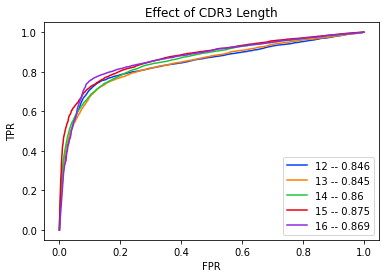

<AxesSubplot:title={'center':'Effect of CDR3 Length'}, xlabel='FPR', ylabel='TPR'>

In [17]:
import os
aipt_reload(AIPT.Utils.plotting)
from AIPT.Utils.plotting import roc_from_models

models = {}
test_loaders = {}
length_dir = os.path.join(model_dir_abs, "results", "length")
# def length_effect_roc(length_range, embedding_type, model_getter, para_dict, random_seed=0)
for length in range(12, 17):
    print(length)
    para_dict = para_dict.copy()
    para_dict["seq_len"] = length
    data = load_data(index_df, seq_len=length)
    np.random.seed(0)
    torch.manual_seed(0)
    _, test_loader = get_train_test_loaders(data)
    test_loaders[str(length)] = test_loader
    embedding_type = "general"
    model_getter = get_general_model
    model_weights_path = os.path.join(
        length_dir, str(length), f"{embedding_type}_100", "model", "best"
    )
    model = model_getter(para_dict)
    model.net_init()
    model.load_state_dict(torch.load(model_weights_path))
    models[str(length)] = model
    print('\n')
    
save_path = os.path.join(length_dir, f"{embedding_type}.png")

roc_from_models(
    models, test_loaders, title=f"Effect of CDR3 Length", save_path=save_path
)

## Test on DeepCAT dataset

In [ ]:
aipt_reload(AIPT.Models.Beshnova2020.CNN)
aipt_reload(AIPT.Utils.logging)
aipt_reload(AIPT.Utils.plotting)
from AIPT.Models.Beshnova2020.CNN import CNN
import AIPT.Models.Beshnova2020.pca_embedding as pca_embedding
from AIPT.Utils.logging import today, current_time
from AIPT.Utils.plotting import plot_roc_curves

In [ ]:
log_root_dir = 's3://gv20interns/roger/logs/tensorboard'
run_name = 'deepcat_test'
timezone = 'EST'

para_dict = {
#     'seq_len': 12,
    'embedding_dim': 15, # paper uses dim 15 PCA features
#     'epoch': 1000,
    'classes': ['normal', 'tumor'],
    'learning_rate': 10**-3,
    'run_name': run_name,
    'log_dir': os.path.join(log_root_dir, today(tz=timezone), run_name, current_time(tz=timezone)),
    'work_path': os.path.join(model_dir_abs, 'work/DeepCAT')
}



In [ ]:
import pandas as pd

data_dir = os.path.join(model_dir_abs, 'data')
fnormal = os.path.join(data_dir, 'NormalCDR3.txt')
ftumor = os.path.join(data_dir, 'TumorCDR3.txt')

def load_deepcat_data(ftumor, fnormal, seq_len = 12):
    tumorCDR3s=[]
    g=open(ftumor)
    for ll in g.readlines():
        rr=ll.strip()
        if not rr.startswith('C') or not rr.endswith('F'):
            print("Non-standard CDR3s. Skipping.")
            continue
        if len(rr) != seq_len:
            continue
        tumorCDR3s.append(rr)
    normalCDR3s=[]
    g=open(fnormal)
    for ll in g.readlines():
        rr=ll.strip()
        if not rr.startswith('C') or not rr.endswith('F'):
            print("Non-standard CDR3s. Skipping.")
            continue
        if len(rr) != seq_len:
            continue
        normalCDR3s.append(rr)
        
    normal_df = pd.DataFrame(normalCDR3s)
    normal_df.columns = ['CDR3_aa']
    normal_df['label'] = 0

    tumor_df = pd.DataFrame(tumorCDR3s)
    tumor_df.columns = ['CDR3_aa']
    tumor_df['label'] = 1

    data_df = pd.concat([normal_df, tumor_df])
    return data_df
    

In [ ]:
seq_lengths = range(12, 17)
accs = {}
for seq_length in seq_lengths:
    
    dc_para_dict = para_dict.copy()
    dc_para_dict['seq_len'] = seq_length
    
    data_df = load_deepcat_data(ftumor, fnormal, seq_len=seq_length)
    print(data_df)
    dc_train_loader = get_data_loader(data_df)
    
    num_batches = len(dc_train_loader)
    dc_steps = 40000
    dc_para_dict['epoch'] = dc_steps//num_batches
    dc_para_dict['model_name'] = f'deepcat_torch_seqlen{seq_length}'
    pca_embedding_fn = pca_embedding.embedding_fn(20, dc_para_dict['embedding_dim'])
    dc_model = CNN(dc_para_dict, pca_embedding_fn)
    
    results = dc_model.fit(dc_train_loader)
    accs[seq_length] = results['train']['acc']

In [ ]:
print(accs)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pt_results = accs
tf_results = {
    12: 0.8610463741917541,
    13: 0.8308455045175356,
    14: 0.7865194836315643,
    15: 0.82875444017,
    16: 0.85230856924342,
}
def get_results_df(results_dict, framework):
    lengths = results_dict.keys()
    accs = results_dict.values()
    df = pd.DataFrame.from_dict({'seq_len': lengths, 'acc': accs})
    df['Framework'] = framework
    return df


df_path = os.path.join(model_dir_abs, 'comparison.csv')
if os.path.isfile(df_path):
    df = pd.read_csv(df_path)
else:
    pt_df = get_results_df(pt_results, framework='PyTorch')
    tf_df = get_results_df(tf_results, framework='TensorFlow')
    df = pd.concat([pt_df, tf_df])
    df.to_csv(df_path)
print(df)

sns.color_palette('bright')
fig = sns.barplot(data=df, x='seq_len', y='acc', hue='Framework')
fig.set(xlabel='Sequence Length', ylabel='Accuracy', title='DeepCAT Reimplementation Accuracies')
fig_path = os.path.join(model_dir_abs, 'comparision.png')
fig.figure.savefig(fig_path, dpi=300)